# DA - Project 3
* Oskar Szudzik 148245,
* Krystian Moras 148243

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('monodata/breast cancer.csv', header=None)
data = data.drop_duplicates()

criteria_nr = 7
target_map = {1: 0, 2: 1}
data[criteria_nr] = data[criteria_nr].apply(lambda x: target_map[x])

data_input = data.iloc[:, :criteria_nr]
data_target = data[criteria_nr]

data_input, data_target

(       0         1      2    3    4    5    6
 0    1.0  0.500000  0.000  1.0  1.0  1.0  0.0
 1    0.5  0.500000  0.000  0.0  0.0  1.0  0.0
 2    0.5  0.833333  0.000  0.0  0.5  0.0  0.0
 3    1.0  0.833333  0.000  1.0  1.0  1.0  1.0
 4    1.0  1.000000  0.125  1.0  0.5  0.0  0.0
 ..   ...       ...    ...  ...  ...  ...  ...
 270  1.0  1.000000  0.125  1.0  0.5  0.0  1.0
 272  0.5  0.500000  0.000  0.0  1.0  1.0  1.0
 273  0.5  1.000000  0.250  1.0  0.5  0.0  0.0
 274  1.0  0.833333  0.125  1.0  0.5  0.0  1.0
 275  1.0  1.000000  0.250  1.0  0.5  1.0  0.0
 
 [173 rows x 7 columns],
 0      1
 1      0
 2      1
 3      0
 4      1
       ..
 270    0
 272    0
 273    0
 274    0
 275    0
 Name: 7, Length: 173, dtype: int64)

## ML model - XGBoost

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target, test_size=0.2, random_state=667
)

In [4]:
params = {
    "max_depth": criteria_nr // 2,
    "eta": 0.1,
    "nthread": 2,
    "seed": 667,
    "eval_metric": "rmse",
    "monotone_constraints": "(" + ",".join(["1"] * criteria_nr) + ")",
    "n_estimators": 1,
}

model = xgb.XGBClassifier(**params)

_ =model.fit(X_train, y_train)

In [5]:
from helpers import *

### Accuracy, F1, AUC

In [6]:
# TRAIN
y_pred = model.predict(X_train)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_train, predictions)
print("Accuracy train: %.4f%%" % (accuracy * 100.0))

fpr, tpr, thresholds = roc_curve(y_train, predictions, pos_label=1)
auc_tr = auc(fpr, tpr)
print("AUC train: %.4f%%" % (auc_tr * 100))

f1_train = f1_score(y_train, predictions, average='binary', pos_label=1)
print("F1 train: %.4f%%" % (f1_train * 100))

# TEST
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy test: %.4f%%" % (accuracy * 100.0))

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
auc_te = auc(fpr, tpr)
print("AUC test: %.4f%%" % (auc_te * 100))

f1_test = f1_score(y_test, predictions, average='binary', pos_label=1)
print("F1 test: %.4f%%" % (f1_test * 100))

Accuracy train: 68.8406%
AUC train: 63.8228%
F1 train: 50.5747%
Accuracy test: 68.5714%
AUC test: 63.0952%
F1 test: 47.6190%


<Axes: >

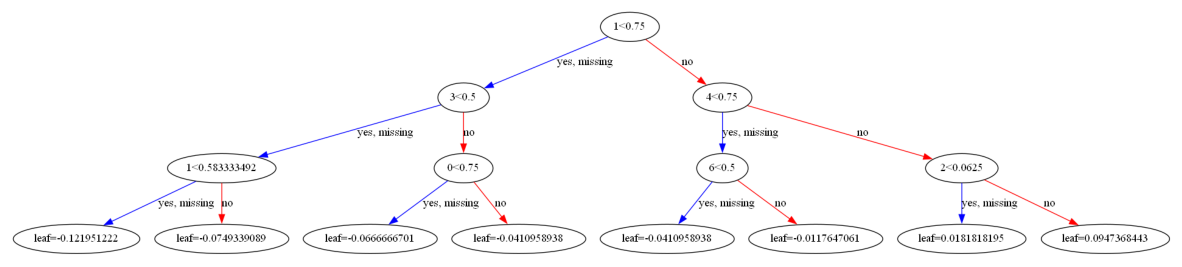

In [10]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(model, ax=ax, num_trees=0)

### Partial dependency plots


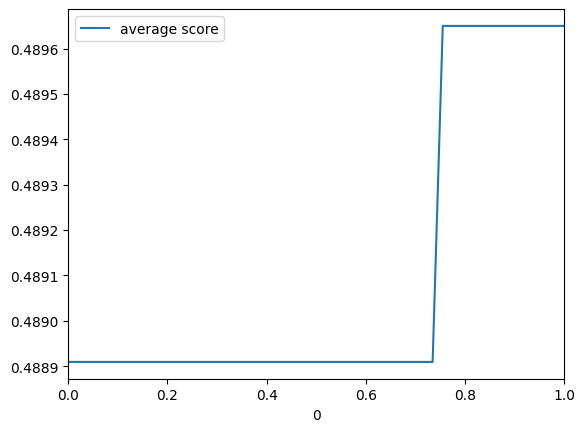

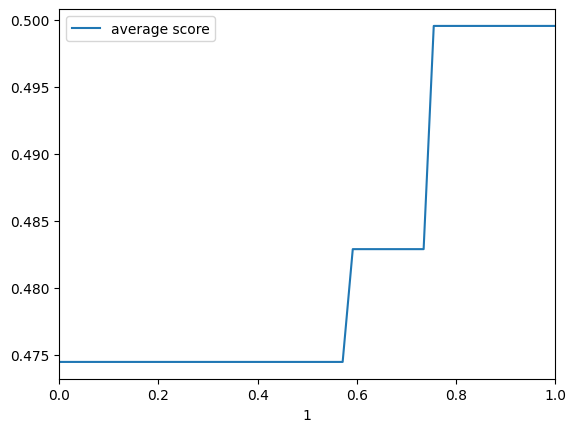

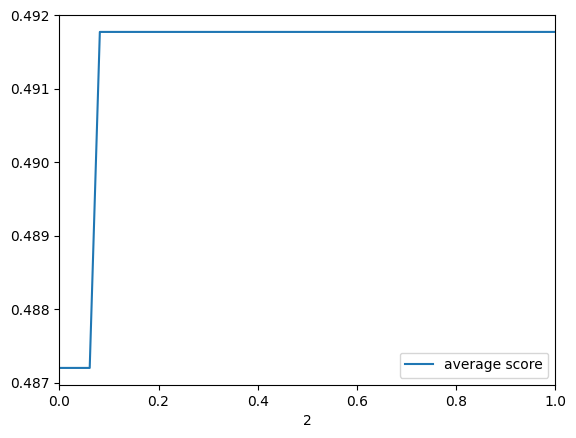

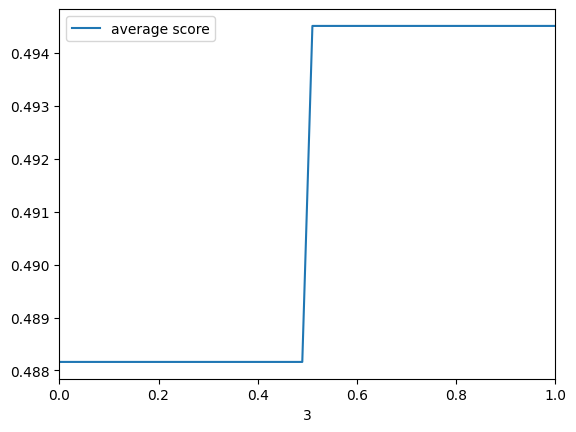

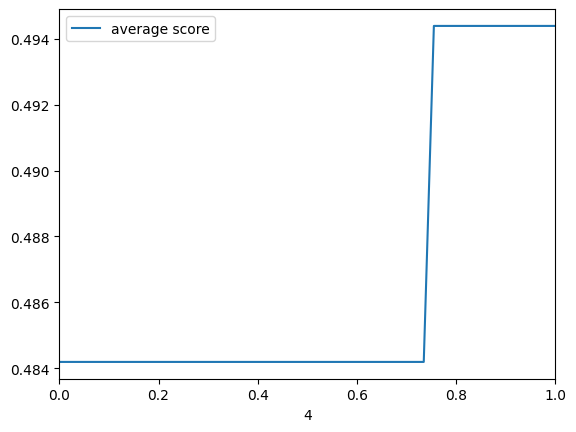

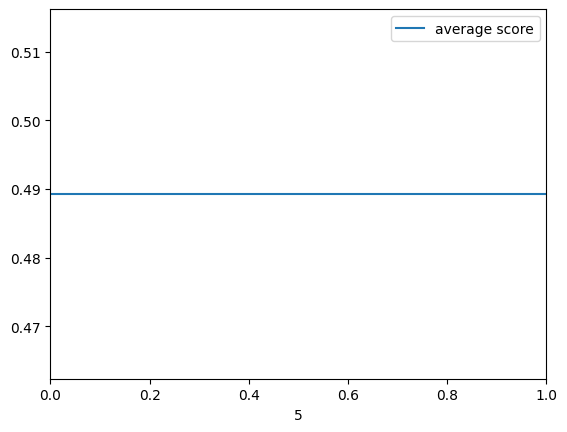

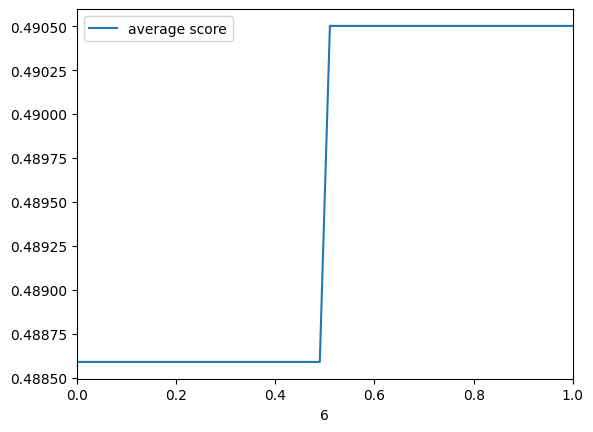

In [11]:
booster = model.get_booster()
grid = np.linspace(0,1,50)
for c in range(criteria_nr):
    y_pred = np.zeros(len(grid))
    for i, val in enumerate(grid):
        X_temp = X_train.values.copy()
        X_temp[:, c] = val
        data = xgb.DMatrix( pd.DataFrame(X_temp) )
        y_pred[i] = np.average(booster.predict(data))
        
    fig, ax = plt.subplots()
    ax.plot(grid, y_pred,  label='average score')
    ax.set_xlim(0, 1)
    ax.set_xlabel(c)
    ax.legend()

In [12]:
booster.get_fscore()

{'0': 1.0, '1': 2.0, '2': 1.0, '3': 1.0, '4': 1.0, '6': 1.0}

We decided on the lower depth of the tree, since its metrics seem no-worse than deeper models.

Based on the model tree we can deduce that 5th criteria has very marginal effect on the decision. Also we see that 1st and 4th criteria are the most decisive.

Furthermore, looking at the partial dependency plots - we get the confirmation about our predictions. 1st and 4th plots picture the most interesting relations and 5th is linear.

### Thresholds for other decision for given alternative

In [13]:
print(X_test[:3])
print(y_test[:3], predictions[:3])

       0         1     2    3    4    5    6
69   1.0  0.833333  0.25  1.0  1.0  0.0  1.0
178  0.5  0.500000  0.00  0.0  0.0  0.0  0.0
115  1.0  0.833333  0.00  1.0  0.5  0.0  0.0
69     1
178    0
115    0
Name: 7, dtype: int64 [1, 0, 0]


Looking at the model tree we see that first 3 alternatives are classified correctly.
The minimal change to a single criterion to be classified to the other class:
* 1st record: 1st criterion -> 0.75 - 0.83 = -0.08
* 2nd record: 1st criterion -> 0.75 - 0.5 = +0.25; 4th criterion -> +0.75
* 3rd record: 4th criterion -> 0.75 - 0.5 = +0.25

And the final confirmation from SHAP values.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


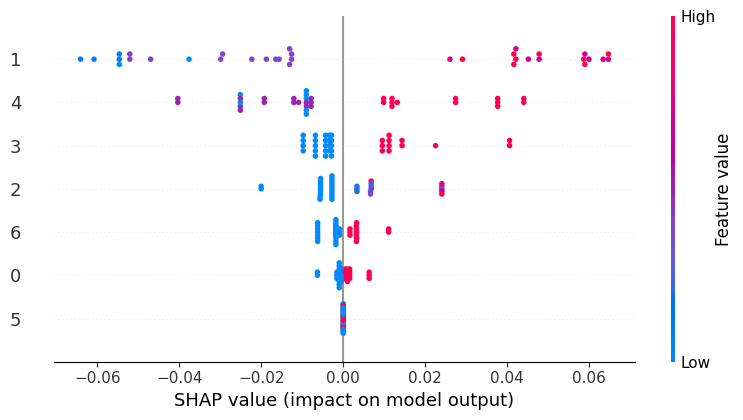

In [14]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

## Neural MCDA method - ANN-UTADIS

In [15]:
from nb_UTA import *

In [16]:
data = pd.read_csv('monodata/breast cancer.csv', header=None)
data = data.drop_duplicates()

criteria_nr = 7
target_map = {1: 0, 2: 1}
data_target = data[criteria_nr].apply(lambda x: target_map[x])
data_input = data.iloc[:, :criteria_nr]
data_input = data_input.values.reshape(-1, 1, criteria_nr)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=667
)

In [17]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [18]:
PATH = "uta.pt2"
uta = Uta(criteria_nr, 30)
model = NormLayer(uta, criteria_nr)

acc, acc_test, auc, auc_test, f1, f1_test = Train(model, train_dataloader, test_dataloader, PATH)

print("Accuracy train:\t%.4f%%" % (acc * 100.0))
print("AUC train: \t%.4f%%" % (auc * 100.0))
print("F1 train: \t%.4f%%" % (f1 * 100))

print()

print("Accuracy test:\t%.4f%%" % (acc_test * 100.0))
print("AUC test: \t%.4f%%" % (auc_test * 100.0))
print("F1 test: %.4f%%" % (f1_test * 100))

100%|██████████| 200/200 [00:05<00:00, 33.84it/s]

Accuracy train:	66.6667%
AUC train: 	69.1248%
F1 train: 	0.0000%

Accuracy test:	60.0000%
AUC test: 	71.9388%
F1 test: 0.0000%


In [19]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [20]:
def getSimpleInput(val):
    return torch.FloatTensor([[val] * criteria_nr]).view(1, 1, -1).cpu()


hook = Hook(model.method.criterionLayerCombine, append_output)
xs = []
with torch.no_grad():
    for i in range(69):
        val = i / 68.0
        x = getSimpleInput(val)
        xs.append(val)
        uta(x)

outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())
outs = outs * model.method.sum_layer.weight.detach().numpy()[0]
outs = outs[::3] - outs[::3][0]
outs = outs / outs[-1].sum()

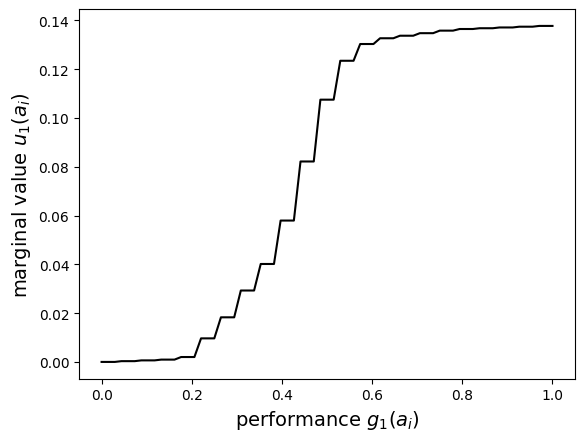

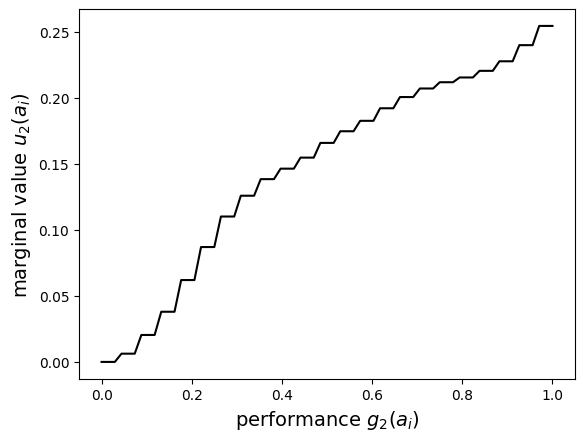

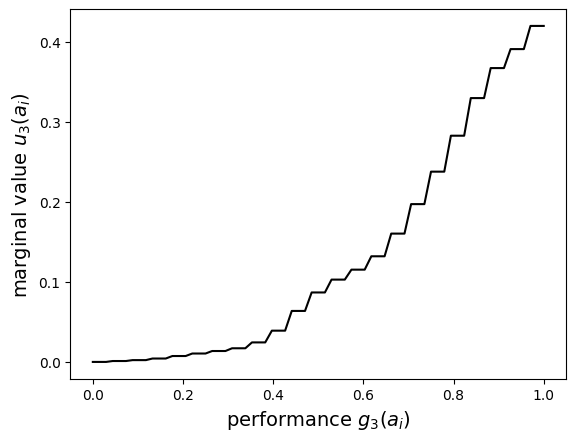

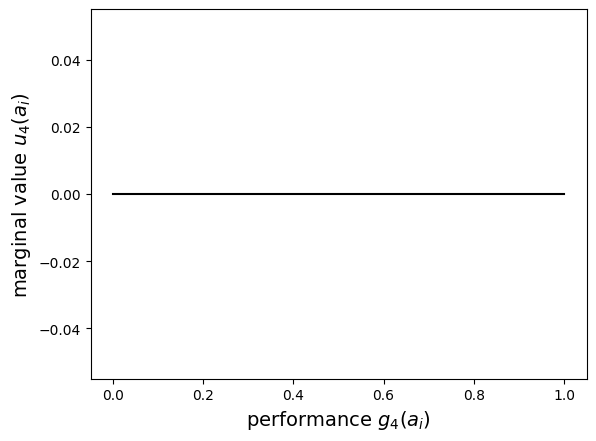

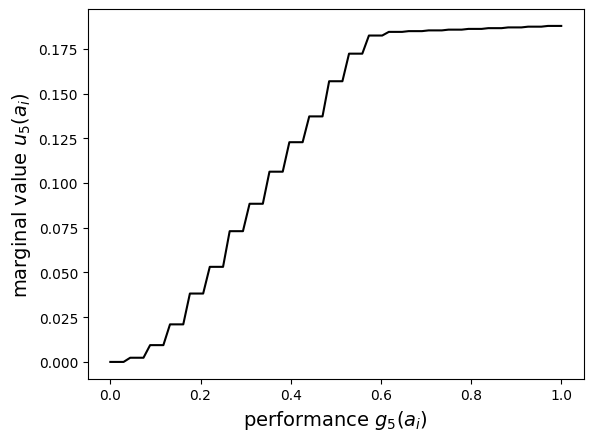

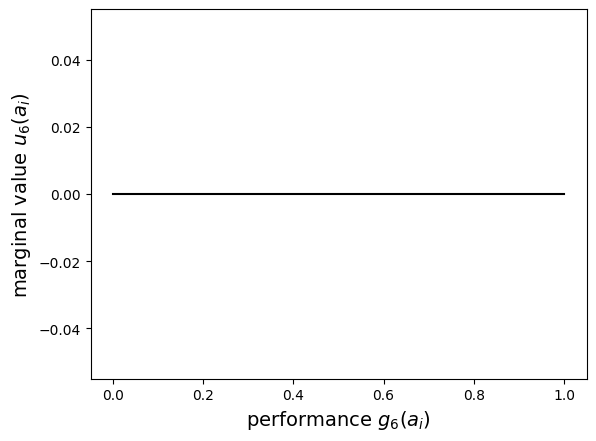

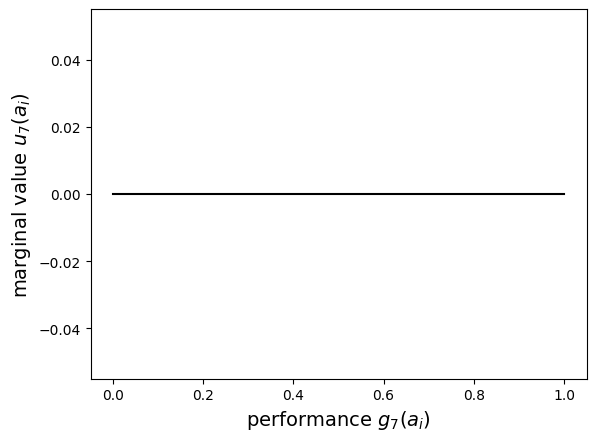

In [21]:
for i in range(criteria_nr):
    y = outs[:, i]
    plt.plot(xs, y.repeat(3), color="black")
    plt.ylabel("marginal value $u_{0}(a_i)$".format(i + 1), fontsize=14)
    plt.xlabel("performance $g_{0}(a_i)$".format(i + 1), fontsize=14)
    plt.show()

### Thresholds for other decision for given alternative

In [22]:
def find_thresholds(model,alternative):
    print("Values:")
    print(alternative)
    original_decision = model(torch.tensor([alternative])).item() > 0
    print("original decision: {0}".format(original_decision))
    print("Thresholds for different decision:")
    for criterion in range(len(alternative[0])):
        new_x = alternative.copy()
        first_i = None
        last_i = None
        for i in range(1001):
            new_x[0][criterion] = i / 1000.0
            new_decision = model(torch.tensor([new_x])).item() > 0
            if new_decision != original_decision:
                if first_i is None:
                    first_i = i
                last_i = i
        if first_i is None and last_i is None:
            print(f"criterion {criterion+1} no value found")
        else:
            print("criterion {0} threshold: {1} {2}".format(criterion+1, first_i / 1000.0, last_i / 1000.0))

find_thresholds(model,X_test[0])

find_thresholds(model,X_test[1])

find_thresholds(model,X_test[2])


Values:
[[1.       0.833333 0.25     1.       1.       0.       1.      ]]
original decision: True
Thresholds for different decision:


Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:204.)


criterion 1 threshold: 0.0 0.456
criterion 2 threshold: 0.0 0.522
criterion 3 no value found
criterion 4 no value found
criterion 5 threshold: 0.0 0.451
criterion 6 no value found
criterion 7 no value found
Values:
[[0.5 0.5 0.  0.  0.  0.  0. ]]
original decision: False
Thresholds for different decision:
criterion 1 no value found
criterion 2 no value found
criterion 3 threshold: 0.742 1.0
criterion 4 no value found
criterion 5 no value found
criterion 6 no value found
criterion 7 no value found
Values:
[[1.       0.833333 0.       1.       0.5      0.       0.      ]]
original decision: True
Thresholds for different decision:
criterion 1 threshold: 0.0 0.563
criterion 2 threshold: 0.0 0.745
criterion 3 no value found
criterion 4 no value found
criterion 5 threshold: 0.0 0.479
criterion 6 no value found
criterion 7 no value found


In [23]:
shap.initjs()

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


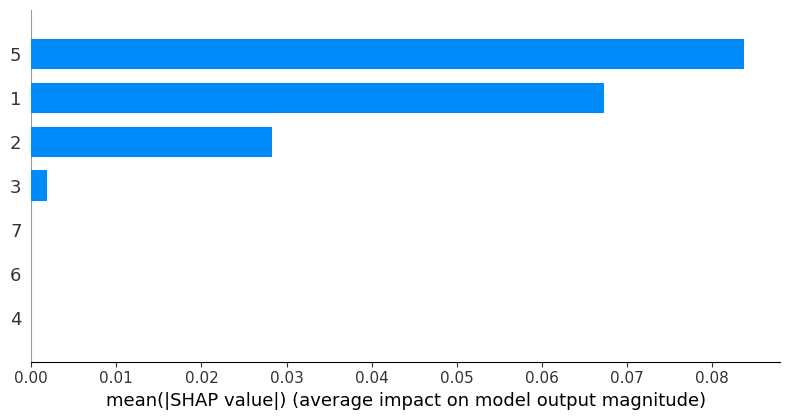

In [24]:
explainer = shap.DeepExplainer(model, torch.tensor(X_train))

def explain_prediction_with_shap(alternative):
    shap_values = explainer.shap_values(torch.tensor([alternative]))
    shap_values = shap_values[0]
    test = np.squeeze(alternative)
    return shap.summary_plot(shap_values, alternative, feature_names=["1","2","3","4","5","6","7"],plot_type="bar")

explain_prediction_with_shap(X_test[0])

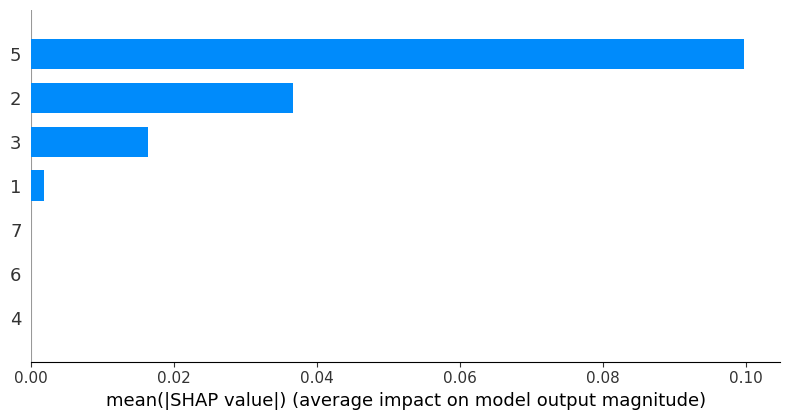

In [25]:
explain_prediction_with_shap(X_test[1])

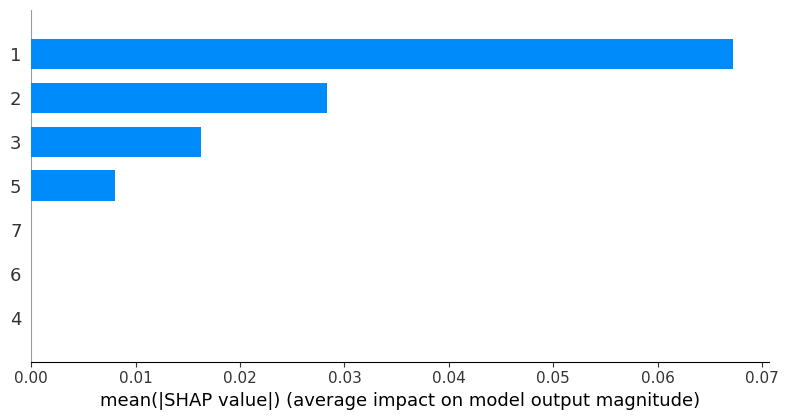

In [26]:
explain_prediction_with_shap(X_test[2])

### Neural Network

In [27]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralNetwork, self).__init__()
        self.bc1 = nn.BatchNorm1d(hidden_dim)
        self.bc2 = nn.BatchNorm1d(hidden_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 2)
        # binary classification
        

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.bc2(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc4(x)
        
        return x
    


In [28]:
import pytorch_lightning as pl
import torchmetrics

class LightningModule(pl.LightningModule):

    def __init__(self, criteria_nr, hidden_dims):
        super().__init__()
        self.model = NeuralNetwork(criteria_nr, hidden_dims)
        self.accuracy = torchmetrics.Accuracy(task="binary")
        self.f1 = torchmetrics.classification.BinaryF1Score()
        self.auc = torchmetrics.classification.BinaryAUROC(thresholds=None)
    def training_step(self, batch, batch_idx):
        x, y = batch

        x = x.view(x.size(0), -1)
        y_hat = self.model(x)
        # binary classification loss
        loss = F.cross_entropy(y_hat, y)

        # predicted class
        preds = torch.argmax(y_hat, dim=1)
        acc = self.accuracy(preds, y)
        f1 = self.f1(preds, y)
        auc = self.auc(preds, y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_f1", f1, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_auc", auc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch

        x = x.view(x.size(0), -1)
        y_hat = self.model(x)
        # binary classification loss
        loss = F.cross_entropy(y_hat, y)

        # predicted class
        preds = torch.argmax(y_hat, dim=1)
        acc = self.accuracy(preds, y)
        f1 = self.f1(preds, y)
        auc = self.auc(preds, y)

        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_f1", f1, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_auc", auc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [45]:
data = pd.read_csv('monodata/breast cancer.csv', header=None)
data = data.drop_duplicates()

criteria_nr = len(data.columns)-1
data_target = data[criteria_nr]
data_input = data.iloc[:, :criteria_nr]

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=667
)

In [47]:
class NumpyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data,dtype=torch.float32)
        self.targets = torch.tensor(targets,dtype=torch.int64) - 1

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

    def __len__(self):
        return len(self.data)


train_dataset = NumpyDataset(X_train.to_numpy(), y_train)
test_dataset = NumpyDataset(X_test.to_numpy(), y_test)

In [51]:
X_test.iloc[0]

0    1.000000
1    0.833333
2    0.250000
3    1.000000
4    1.000000
5    0.000000
6    1.000000
Name: 69, dtype: float64

In [52]:
train_dataset[0], test_dataset[0]

((tensor([1.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor(1)),
 (tensor([1.0000, 0.8333, 0.2500, 1.0000, 1.0000, 0.0000, 1.0000]), tensor(1)))

In [53]:
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [54]:
module = LightningModule(criteria_nr, 100)

trainer = pl.Trainer(max_epochs=15,log_every_n_steps=1)
trainer.fit(module, train_dataloader)
acc = trainer.callback_metrics["train_acc"]
auc = trainer.callback_metrics["train_auc"]
f1 = trainer.callback_metrics["train_f1"]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type           | Params
--------------------------------------------
0 | model    | NeuralNetwork  | 21.6 K
1 | accuracy | BinaryAccuracy | 0     
2 | f1       | BinaryF1Score  | 0     
3 | auc      | BinaryAUROC    | 0     
--------------------------------------------
21.6 K    Trainable params
0         Non-trainable params
21.6 K    Total params
0.086     Total estimated model params size (MB)
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [55]:
# accuracy on test set
trainer.test(module,test_dataloader)

acc_test = trainer.callback_metrics["test_acc"]

auc_test = trainer.callback_metrics["test_auc"]

f1_test = trainer.callback_metrics["test_f1"]

The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7714285850524902     │
│         test_auc          │    0.7261905074119568     │
│          test_f1          │    0.6363636255264282     │
│         test_loss         │     0.633112907409668     │
└───────────────────────────┴───────────────────────────┘

In [56]:
print("Accuracy train:\t%.4f%%" % (acc * 100.0))
print("AUC train: \t%.4f%%" % (auc * 100.0))
print("F1 train: \t%.4f%%" % (f1 * 100))

print()

print("Accuracy test:\t%.4f%%" % (acc_test * 100.0))
print("AUC test: \t%.4f%%" % (auc_test * 100.0))
print("F1 test: %.4f%%" % (f1_test * 100))

Accuracy train:	68.1159%
AUC train: 	64.5503%
F1 train: 	54.1667%

Accuracy test:	77.1429%
AUC test: 	72.6190%
F1 test: 63.6364%


In [68]:
def find_thresholds(model,alternative):
    model.eval()
    print("Values:")
    print(alternative)
    original_decision = torch.argmax(model(alternative))
    print("original decision: {0}".format(original_decision))
    criteria_decisions = {}
    for criterion in range(len(alternative[0])):
        new_x = torch.clone(alternative)
        first_i = None
        last_i = None
        decisions = []
        for i in range(1001):
            new_x[0][criterion] = i / 1000.0
            new_decision = torch.argmax(model(new_x))
            decisions.append(new_decision)
        
        criteria_decisions[criterion] = decisions

    return criteria_decisions
crit_decisions = find_thresholds(module,test_dataset[0][0].view(1,-1))
crit_decisions

Values:
tensor([[1.0000, 0.8333, 0.2500, 1.0000, 1.0000, 0.0000, 1.0000]])
original decision: 1


{0: [tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(1),
  tensor(

In [67]:
crit_decisions

In [ ]:
module.eval()(test_dataset[0][0].view(1,-1))

tensor([[-0.0829,  0.1466]], grad_fn=<AddmmBackward0>)

#todo : 3 alternatives boundary for another decision

Based on the parameters obtained, can we say something about the user’s
preferences? Are there any criteria that have no effect, or have a decisive
influence. Whether there are any preference thresholds? Are there any
evaluations on criteria that are indifference in terms of preferences?

Take 3 alternatives and say what the minimum change to a single crite-
rion should be done that the option is classified into a different class.
– Try answer this question in an analytical way based only on the values
of the model parameters and explain why such a change is minimal
(without sampling).
– Perform space sampling by slightly changing the evaluations of alter-
natives to get a different class. Do the results agree with theoretical
predictions?
– EExplain the predictions for these objects using at least one tech-
nique (Anchors LIME, SHAP, ... )
• Interpret the model by at least one ( Global Surrogate, Partial Dependence
Plot Permutation Feature Importance ...)